In [131]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

# import pyomo.environ

# Exercise 1

## Setup data 

In [132]:
# CONTROL VARIABLES
batteryOn = False


# DATA
countries = ['DE', 'DK', 'SE']
techs = ['Wind', 'PV', 'Gas', 'Hydro', 'Battery']
efficiency = {'Wind': 1, 'PV': 1, 'Gas': 0.4, 'Hydro': 1, 'Battery': 0.9}
investment_percentages = {
    "Wind": 0.17380352644836272,
    "PV": 0.0018891687657430728,
    "Hydro": 0.44836272040302266,
    "Gas": 0.07556675062972291,
    "Battery": 0
}  # Rough approximations from ekonomifakta.se
discountrate = 0.05
hydro_max =33 * 10**6
percent_hydro_at_start = 0.5
CO2_gas_emission_factor = 0.202

# READ CSV
input_data = pd.read_csv('data/TimeSeries.csv', index_col=[0])
cap_max_data = pd.read_csv('data/capMax.csv', index_col=[0])  # MWh
cost_data = pd.read_csv('data/costs.csv', index_col=[0])

print(f"Total demand DK: {input_data['Load_DK'].sum()/1000}")
print(f"Total demand DE: {input_data['Load_DE'].sum()/1000}")
print(f"Total demand SE: {input_data['Load_SE'].sum()/1000}")


Total demand DK: 43606.417933
Total demand DE: 637617.0658
Total demand SE: 177332.34219999998


## Utility functions

In [133]:
# UTILITY FUNCTIONS
def annualize_cost(tech):
    lifetime = cost_data.loc[tech]["lifetime"]
    return discountrate/(1-1/(1+discountrate)**lifetime)


def investment_cost(model):
    # return sum(max([model.prod[node, tech, t] for t in model.time])*cost_data.loc[tech]["investment_cost"]
    #     * annualize_cost(tech) for tech in model.gens for node in model.nodes)

    return sum(input_data["Load_" + node].sum() * investment_percentages[tech] * cost_data.loc[tech]["investment_cost"] * annualize_cost(tech) for tech in model.gens for node in model.nodes)




def capacity_max(model, n, g):
    capMax = {}
    if g in cap_max_data.columns:
        capMax[n, g] = float(cap_max_data[g].loc[cap_max_data.index == n])
        return 0.0, capMax[n, g]
    elif g == 'Battery' and not batteryOn:
        return 0.0, 0.0
    else:
        return 0.0, None


def demandData():
    demand = {}
    for n in model.nodes:
        for t in model.time:
            demand[n, t] = input_data.iloc[t][f"Load_{n}"]
    return demand

def get_load_factor(tech, time, node):
    """
    Checks performance of Wind and solar at the provided
    node and time
    """
    if tech != "Wind" and tech != "PV":
        return 1
    text = f"{tech}_{node}"
    return input_data.iloc[time][text]

def get_effective_prod(node,tech,t):
    return model.prod[node, tech, t].value * get_load_factor(tech,t,node) * model.efficiency[tech]

def solve_model():
    opt = SolverFactory("gurobi_direct")
    opt.options["threads"] = 4
    print("========================= SOLVING MODEL =========================")

    return opt.solve(model, tee=True)

## Create model and sets

In [134]:
model = ConcreteModel()

model.nodes = Set(initialize=countries, doc='countries')
model.time = Set(initialize=input_data.index, doc='hours')
model.gens = Set(initialize=techs, doc="Technologies")



## Set parameters

In [135]:
model.demand = Param(model.nodes, model.time, initialize=demandData())
model.efficiency = Param(
    model.gens, initialize=efficiency, doc='Conversion efficiency')

## Create variables

In [136]:
# VARIABLES
model.prod = Var(model.nodes, model.gens, model.time,
                 domain=NonNegativeReals,
                 doc="Production")
model.capa = Var(model.nodes, model.gens,
                 bounds=capacity_max, doc='Generator cap')
model.water_level = Var(model.time, bounds=(0, hydro_max), doc="Water level of reservoir")


## Set constraints

In [137]:

# CONSTRAINTS
# Production is limited by max capacity
def production_capacity_rule(model, nodes, gens, time):
    return model.prod[nodes, gens, time] <= model.capa[nodes, gens]

model.production_constraint = Constraint(model.nodes, model.gens,
                                         model.time, rule=production_capacity_rule)


# Total supply at each hours must meet the demand.
def demand_rule(model, nodes, gens, time):
    return sum([model.prod[nodes, tech, time] * get_load_factor(tech,time,nodes) * model.efficiency[tech] for tech in techs]) >= model.demand[nodes, time]

model.demand_constraint = Constraint(model.nodes, model.gens,
                                     model.time, rule=demand_rule)

# Producing electricity from hydro must decrease water level
def hydro_rule(model,time):
    if (time > 0):
        return model.water_level[time] == model.water_level[time - 1] - model.prod["SE", "Hydro", time] + input_data.iloc[time]["Hydro_inflow"]
    else:
        return model.water_level[time] == model.water_level[time] 

model.hydro_constraint = Constraint(model.time, rule=hydro_rule)


# Starting water level
model.water_start_constraint = Constraint(expr=model.water_level[0] == percent_hydro_at_start*hydro_max)

# Ending water_level
model.water_end_constraint = Constraint(expr=model.water_level[8759] >= model.water_level[0])




## Set objective function

In [138]:
def objective_rule(model):
    return sum(model.prod[node, tech, t] * (cost_data.loc[tech]["variable_cost"] + cost_data.loc[tech]["fuel_cost"]) for node in model.nodes for tech in model.gens for t in model.time) + investment_cost(model)

# def objective_rule(model):
#     return sum(model.prod[node, tech, t] * (cost_data.loc[tech]["variable_cost"] + cost_data.loc[tech]["fuel_cost"] + cost_data.loc[tech]["investment_cost"] * annualize_cost(tech) ) for node in model.nodes for tech in model.gens for t in model.time) 


model.objective = Objective(
    rule=objective_rule, sense=minimize, doc='Objective function')

## Solve model

In [139]:

results = solve_model()
results.write()

========================= SOLVING MODEL =========================
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown_copy
  Lower bound: 14044922046409.803
  Upper bound: 14044922046409.803
  Number of objectives: 1
  Number of constraints: 271562
  Number of variables: 140175
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 140175
  Number of nonzeros: 881920
  Sense: 1
  Number of solutions: 1
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Name: Gurobi 9.11
  Status: ok
  Wallclock time: 2.1910171508789062
  Termination condition

## Calculate production

In [140]:
# Reading output - example
prodTot = {}
for node in model.nodes:
    for tech in model.gens:
        for t in model.time:
            if not (node, tech) in prodTot:
                prodTot[node, tech] = round(get_effective_prod(node, tech, t) /1e3) # GW
            else:
                prodTot[node, tech] += round(get_effective_prod(node, tech, t) /1e3)

costTot = value(model.objective) / 1e6  # Million EUR
pprint.pprint(prodTot)
print(f"Total cost: {round(costTot)}")

total_co2 = CO2_gas_emission_factor * (prodTot["DE","Gas"] + prodTot["DK","Gas"] + prodTot["SE","Gas"]) * 1000 # MWh
print(f"Total CO2 emission: {total_co2} tons CO2")


{('DE', 'Battery'): 0,
 ('DE', 'Gas'): 133563,
 ('DE', 'Hydro'): 0,
 ('DE', 'PV'): 194034,
 ('DE', 'Wind'): 309989,
 ('DK', 'Battery'): 0,
 ('DK', 'Gas'): 758,
 ('DK', 'Hydro'): 0,
 ('DK', 'PV'): 9274,
 ('DK', 'Wind'): 33728,
 ('SE', 'Battery'): 0,
 ('SE', 'Gas'): 560,
 ('SE', 'Hydro'): 65014,
 ('SE', 'PV'): 10973,
 ('SE', 'Wind'): 100781}
Total cost: 14044922
Total CO2 emission: 27245962.000000004 tons CO2


## Plot capacitites

{('DE', 'Battery'): 0,
 ('DE', 'Gas'): 229,
 ('DE', 'Hydro'): 0,
 ('DE', 'PV'): 460,
 ('DE', 'Wind'): 180,
 ('DK', 'Battery'): 0,
 ('DK', 'Gas'): 15,
 ('DK', 'Hydro'): 0,
 ('DK', 'PV'): 60,
 ('DK', 'Wind'): 90,
 ('SE', 'Battery'): 0,
 ('SE', 'Gas'): 31,
 ('SE', 'Hydro'): 14,
 ('SE', 'PV'): 75,
 ('SE', 'Wind'): 280}


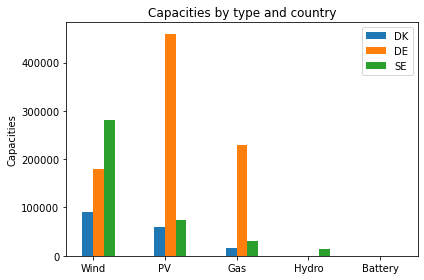

In [141]:
capTot = {}
for n in model.nodes:
    for g in model.gens:
        capTot[n, g] = round(model.capa[n, g].value/1e3) #GW

pprint.pprint(capTot)

dk_cap = [model.capa["DK",tech].value for tech in model.gens]
de_cap = [model.capa["DE",tech].value for tech in model.gens]
se_cap = [model.capa["SE",tech].value for tech in model.gens]


labels = [tech for tech in model.gens]
x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dk_cap, width, label='DK')
rects2 = ax.bar(x + width/2, de_cap, width, label='DE')
rects3 = ax.bar(x + width*3/2, se_cap, width, label='SE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Capacities')
ax.set_title('Capacities by type and country')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

## Plot first week in Germany

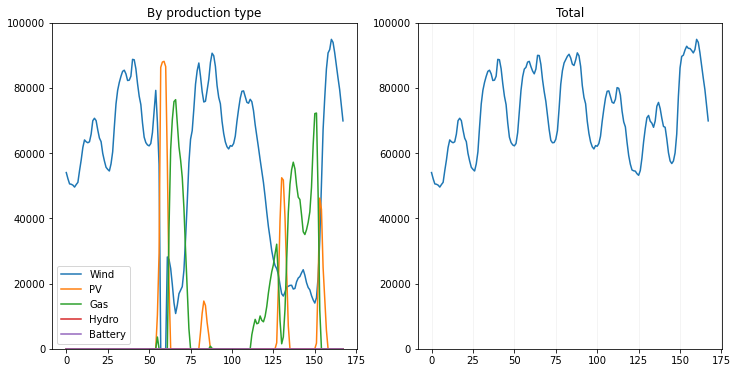

In [142]:
de_time = range(0,168)
de_wind = np.array([ get_effective_prod("DE", "Wind", t) for t in de_time])
de_pv = np.array([ get_effective_prod("DE", "PV", t) for t in de_time])
de_gas = np.array([ get_effective_prod("DE", "Gas", t) for t in de_time])
de_hydro = np.array([ get_effective_prod("DE", "Hydro", t) for t in de_time])
de_battery = np.array([ get_effective_prod("DE", "Battery", t) for t in de_time])
de_total = de_wind + de_pv + de_gas + de_hydro + de_battery

f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(12)

ax1.set_ylim([0,100000])
ax2.set_ylim([0,100000])

ax1.plot(de_time, de_wind)
ax1.plot(de_time, de_pv)
ax1.plot(de_time, de_gas)
ax1.plot(de_time, de_hydro)
ax1.plot(de_time, de_battery)

ax2.plot(de_time, de_total)


plt.grid(axis='x', color='0.95')
ax1.legend(["Wind", "PV", "Gas", "Hydro", "Battery"], loc="lower left")
ax1.set_title('By production type')
ax2.set_title('Total')

plt.show()



# Exercise 2

## Add CO2 constraint

In [145]:
# Total CO generated in cell found previously
co2_limit = 0.1 * total_co2

# Add CO2 limit constraint
model.co2_limit_constraint = Constraint(expr= sum(model.prod[node, "Gas", t] for node in model.nodes for t in model.time) <= co2_limit)

    (type=<class 'pyomo.core.base.constraint.SimpleConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


## Solve model again

In [146]:
results = solve_model()
results.write()

========================= SOLVING MODEL =========================
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: <undefined>
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: None
  Upper bound: None
  Number of objectives: 1
  Number of constraints: 271563
  Number of variables: 140175
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 140175
  Number of nonzeros: 908200
  Sense: 1
  Number of solutions: 0
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Name: Gurobi 9.

## Add batteries

In [ ]:

# Start here, modify the constraints below to focus on batteries in stead. Also create battery_level variable same as for water_level. 

# Producing electricity from hydro must decrease water level
def hydro_rule(model,time):
    if (time > 0):
        return model.water_level[time] == model.water_level[time - 1] - model.prod["SE", "Hydro", time] + input_data.iloc[time]["Hydro_inflow"]
    else:
        return model.water_level[time] == model.water_level[time] 

model.hydro_constraint = Constraint(model.time, rule=hydro_rule)


# Starting water level
model.water_start_constraint = Constraint(expr=model.water_level[0] == percent_hydro_at_start*hydro_max)

# Ending water_level
model.water_end_constraint = Constraint(expr=model.water_level[8759] >= model.water_level[0])